In [1]:
# %% [markdown]
# ## Parameter Definition
# You can later inject this parameter via Papermill.
# dataset_path = "/Users/rooj/Documents/RP3-Main/RP3-Imp/clean-datasets/2018.csv"  # Update as needed


# %% [code]
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os


from sklearn.model_selection import KFold, cross_validate, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



In [ ]:
# # %% [markdown]
# # ## Parameter Definition
# # You can later inject these parameters via Papermill if desired.
# dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update path as needed
# sample_fraction = 0.05  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
# run_name = "logreg_run1-100percent"  # Change as desired
# year = "2018"
# model = "logreg"  # Change as desired

# # Define output folder and create it if needed
# output_folder = os.path.join("Outputs", year, model, run_name)
# os.makedirs(output_folder, exist_ok=True)
# print("Output folder created:", output_folder)

import os

# 1. Parameters and Setup
dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update path as needed
sample_fraction = 0.005  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
run_name = "logreg_run1-100percent"  # Change as desired
model = "logreg"  # Change as desired

# Extract the entire filename (without the extension) from the dataset_path.
filename = os.path.basename(dataset_path)  # e.g., "2018.csv"
csv_name = os.path.splitext(filename)[0]    # e.g., "2018" or "MyDataset" if the file is named that way

# Use csv_name as the dynamic folder name
output_folder = os.path.join("Outputs", csv_name, model, run_name)
os.makedirs(output_folder, exist_ok=True)
print("Output folder created:", output_folder)


In [4]:
# %% [code]
# Data Loading & Basic Information
data = pd.read_csv(dataset_path)
print("Original dataset shape:", data.shape)
print("First few rows:")
print(data.head())
print("\nDataset info:")
print(data.info())
print("\nClass distribution:")
print(data['label'].value_counts())

# %% [code]
# Sample a fraction of the dataset (if desired)
data = data.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
print(f"Dataset shape after sampling {sample_fraction*100:.0f}%:", data.shape)

Original dataset shape: (4339650, 26)
First few rows:
    timestamp  Dst Port  protocol  Flow Duration  Flow Duration_rolling_mean  \
0  1518745716   55250.0       6.0       958807.0                   1815614.1   
1  1519099848     443.0       6.0      6081730.0                   2284039.7   
2  1519179901   52453.0       6.0         1428.0                      6703.5   
3  1518659728    3389.0       6.0      2169521.0                   9191415.4   
4  1519116456   49913.0       6.0           97.0                  24709922.5   

   Flow Duration_rolling_std  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0               1.965582e+06           5.0           3.0            935.0   
1               2.888929e+06          10.0          12.0            646.0   
2               8.135168e+03           5.0           2.0            935.0   
3               2.752269e+07           8.0           7.0           1132.0   
4               4.818137e+07           3.0           1.0             31.0   

  

In [5]:
# %% [code]
# Sample a fraction of the dataset (if desired)
data = data.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
print(f"Dataset shape after sampling {sample_fraction*100:.0f}%:", data.shape)

# Remove rows where the 'label' column equals 'Label' (if misread as data)
data = data[data['label'] != 'label']
print("\nUnique labels after filtering:")
print(data['label'].unique())

# %% [code]
# Dynamically encode the labels using factorize.
# This returns integer codes and a corresponding array of unique labels.
data['label'], uniques = pd.factorize(data['label'])
label_names = {i: label for i, label in enumerate(uniques)}
print("\nEncoded labels mapping:")
print(label_names)

Dataset shape after sampling 100%: (4339650, 26)

Unique labels after filtering:
['DDOS attack-HOIC' 'Benign' 'DDoS attacks-LOIC-HTTP' 'DoS attacks-Hulk'
 'DoS attacks-SlowHTTPTest' 'DoS attacks-GoldenEye'
 'DoS attacks-Slowloris' 'DDOS attack-LOIC-UDP']

Encoded labels mapping:
{0: 'DDOS attack-HOIC', 1: 'Benign', 2: 'DDoS attacks-LOIC-HTTP', 3: 'DoS attacks-Hulk', 4: 'DoS attacks-SlowHTTPTest', 5: 'DoS attacks-GoldenEye', 6: 'DoS attacks-Slowloris', 7: 'DDOS attack-LOIC-UDP'}


In [6]:
# Print all columns for inspection
print("All columns in the dataset:")
print(data.columns.tolist())

# %% [code]
# Select relevant features.
# Option 1: Manually define a list of features.
manual_features = ['pkts_ratio', 'Tot Bwd Pkts', 'Dst Port', 'Fwd Pkt Len Max',
                   'SYN Flag Cnt', 'byte_per_duration', 'Bwd Pkt Len Min', 'protocol',
                   'Fwd Pkt Len Mean', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Flow Duration',
                   'Flow Duration_rolling_std', 'Flow Duration_rolling_mean', 'Bwd Pkt Len Max',
                   'Fwd IAT Tot', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Fwd IAT Max',
                   'Tot Fwd Pkts', 'Fwd IAT Min', 'Fwd IAT Mean', 'Fwd Pkt Len Std',
                   'entropy_pkt_len']

# Option 2: Automatically select all columns except 'timestamp' and 'label'
try:
    selected_features = manual_features
except NameError:
    selected_features = [col for col in data.columns if col.lower() not in ['timestamp', 'label']]

print("\nSelected features:")
print(selected_features)

# %% [code]
# Create feature matrix X and target vector y
X = data[selected_features]
y = data['label']


All columns in the dataset:
['timestamp', 'Dst Port', 'protocol', 'Flow Duration', 'Flow Duration_rolling_mean', 'Flow Duration_rolling_std', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'SYN Flag Cnt', 'pkts_ratio', 'byte_per_duration', 'entropy_pkt_len', 'Subflow Fwd Byts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'label']

Selected features:
['pkts_ratio', 'Tot Bwd Pkts', 'Dst Port', 'Fwd Pkt Len Max', 'SYN Flag Cnt', 'byte_per_duration', 'Bwd Pkt Len Min', 'protocol', 'Fwd Pkt Len Mean', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Flow Duration', 'Flow Duration_rolling_std', 'Flow Duration_rolling_mean', 'Bwd Pkt Len Max', 'Fwd IAT Tot', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Fwd IAT Max', 'Tot Fwd Pkts', 'Fwd IAT Min', 'Fwd IAT Mean', 'Fwd Pkt Len Std', 'entropy_pkt_len']


In [7]:
# Handle missing values (drop rows with missing feature values)
num_rows_before = X.shape[0]
X = X.dropna()
num_rows_after = X.shape[0]
print("Number of rows dropped due to missing values:", num_rows_before - num_rows_after)

# %% [code]
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# (Optional) Ensure labels are numeric.
if not np.issubdtype(y.dtype, np.number):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    print("Label mapping (via LabelEncoder):")
    print(label_mapping)
    y = y_encoded
else:
    print("Labels are already numeric.")


Number of rows dropped due to missing values: 0
Labels are already numeric.


In [8]:
# %% [code]
# Split the data into Training and Testing Sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42
)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)



Training set shape: (3471720, 24)
Test set shape: (867930, 24)


In [9]:
# %% [code]
# Set up K-Fold Cross-Validation (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced', random_state=42)

# Define scoring metrics using a dictionary
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

In [ ]:

# Perform cross-validation on the entire dataset
cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring=scoring, return_train_score=False)
print("Cross-validation Results on Training Set:")
print("Average Accuracy: {:.4f}".format(np.mean(cv_results['test_accuracy'])))
print("Average Precision (macro): {:.4f}".format(np.mean(cv_results['test_precision_macro'])))
print("Average Recall (macro): {:.4f}".format(np.mean(cv_results['test_recall_macro'])))
print("Average F1-Score (macro): {:.4f}".format(np.mean(cv_results['test_f1_macro'])))
print("\n")


In [ ]:

# Use cross_val_predict to obtain predictions on the training set
y_train_pred = cross_val_predict(model, X_train, y_train, cv=kf)
print("Cross-validation Confusion Matrix on Training Set:")
cm_cv = confusion_matrix(y_train, y_train_pred)
print(cm_cv)
print("\nCross-validation Classification Report on Training Set:")
target_names = [str(label) for label in label_names.values()]
print(classification_report(y_train, y_train_pred, target_names=target_names))



Cross-validation Confusion Matrix on Training Set:
[[1904137      69    1301      25       1   16348    6851       1]
 [     41  369488       1       0       0       0       0       0]
 [     68       0  460880       0       0       0       5       0]
 [      0       2       0  548808       0       0       0       0]
 [      0       0       0       0  111912       0       0       0]
 [     15       0       2       0       0   39746      85       0]
 [      0       0       1       0       0      32   10517       0]
 [      0       0       0       0       0       0       0    1384]]

Cross-validation Classification Report on Training Set:
                          precision    recall  f1-score   support

                  Benign       1.00      0.99      0.99   1928733
        DoS attacks-Hulk       1.00      1.00      1.00    369530
  DDoS attacks-LOIC-HTTP       1.00      1.00      1.00    460953
        DDOS attack-HOIC       1.00      1.00      1.00    548810
DoS attacks-SlowHTTPTes


Test Metrics:
Accuracy: 0.9931261737697741
Precision (macro): 0.9170645607238134
Recall (macro): 0.9979741756240862
F1-Score (macro): 0.9492045490991212

Test Classification Report:
                          precision    recall  f1-score   support

                  Benign       1.00      0.99      0.99    482184
        DoS attacks-Hulk       1.00      1.00      1.00     92382
  DDoS attacks-LOIC-HTTP       1.00      1.00      1.00    115238
        DDOS attack-HOIC       1.00      1.00      1.00    137202
DoS attacks-SlowHTTPTest       1.00      1.00      1.00     27978
   DoS attacks-GoldenEye       0.72      1.00      0.84      9962
   DoS attacks-Slowloris       0.62      1.00      0.77      2638
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       346

                accuracy                           0.99    867930
               macro avg       0.92      1.00      0.95    867930
            weighted avg       1.00      0.99      0.99    867930

Confusion Matrix (Test

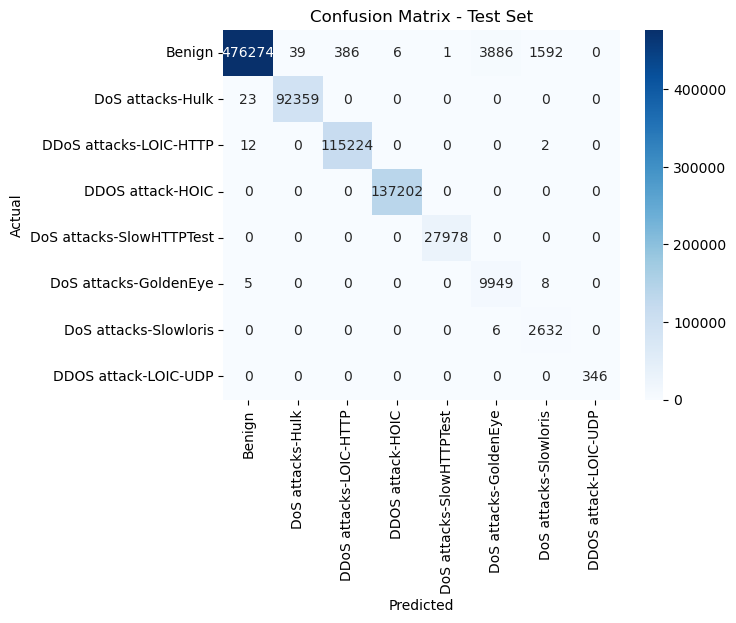

In [ ]:

# %% [code]
# Optionally, train the final model on the entire dataset
model.fit(X_scaled, y)
y_test_pred = model.predict(X_test)

print("\nTest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision (macro):", precision_score(y_test, y_test_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_test_pred, average='macro'))
print("F1-Score (macro):", f1_score(y_test, y_test_pred, average='macro'))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=target_names))
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(cm_test)

# Plot confusion matrix using seaborn heatmap with axis labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


Feature Importance:
                       Feature  Coefficient
1                 Tot Bwd Pkts    61.254180
2                     Dst Port    51.206300
6              Bwd Pkt Len Min    37.960910
4                 SYN Flag Cnt    21.049111
7                     protocol    16.706195
9              TotLen Bwd Pkts    15.519978
3              Fwd Pkt Len Max    15.303082
5            byte_per_duration    12.113503
0                   pkts_ratio     6.788173
11               Flow Duration     6.567588
21                Fwd IAT Mean     6.147155
8             Fwd Pkt Len Mean     5.744015
10             Fwd Pkt Len Min     4.096023
18                 Fwd IAT Max     2.303555
12   Flow Duration_rolling_std     0.723624
13  Flow Duration_rolling_mean    -0.543287
14             Bwd Pkt Len Max    -1.867425
15                 Fwd IAT Tot    -5.215838
16             TotLen Fwd Pkts    -8.742144
17            Subflow Fwd Byts    -8.742144
22             Fwd Pkt Len Std    -9.669286
20         

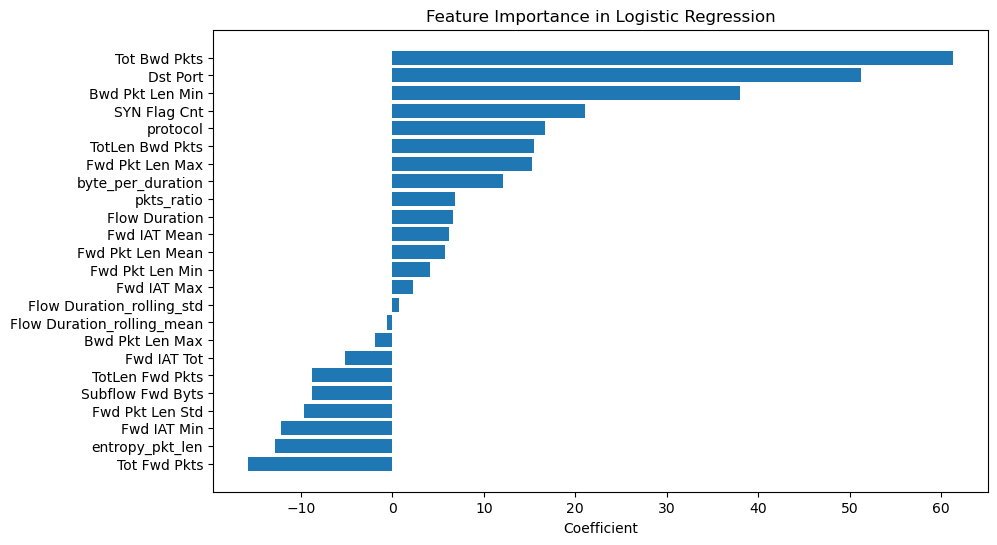

In [ ]:
# %% [code]
# Analyse Feature Importance from Logistic Regression
# (Assuming a linear model, coefficients indicate feature importance)
importance = pd.DataFrame({'Feature': selected_features, 'Coefficient': model.coef_[0]})
importance = importance.sort_values(by='Coefficient', ascending=False)
print("\nFeature Importance:")
print(importance)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

In [ ]:
# %% [code]
# Save outputs and artifacts
# Create a new output folder with a timestamp (if not already created above)

final_output_folder = os.path.join(output_folder, "final_output")
os.makedirs(final_output_folder, exist_ok=True)
print("Final output folder created:", final_output_folder)

# Save final model and scaler
joblib.dump(model, os.path.join(final_output_folder, "logistic_regression_final.pkl"))
joblib.dump(scaler, os.path.join(final_output_folder, "scaler_final.pkl"))
print("Final model and scaler saved.")

# Save test classification report as a text file
test_report = classification_report(y_test, y_test_pred, target_names=target_names)
with open(os.path.join(final_output_folder, "classification_report_test.txt"), "w") as f:
    f.write(test_report)
print("Test classification report saved.")

# Save confusion matrix as CSV
cm_test_df = pd.DataFrame(cm_test, index=target_names, columns=target_names)
cm_test_df.to_csv(os.path.join(final_output_folder, "confusion_matrix_test.csv"), index=True)
print("Confusion matrix saved as CSV.")

# Save confusion matrix heatmap as PNG
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.savefig(os.path.join(final_output_folder, "confusion_matrix_test.png"))
plt.close()
print("Confusion matrix heatmap saved as PNG.")

# Save cross-validation results as CSV
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.to_csv(os.path.join(final_output_folder, "cv_results.csv"), index=False)
print("Cross-validation results saved as CSV.")

# Save feature importance plot as PNG and CSV
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(final_output_folder, "feature_importance.png"))
plt.close()
print("Feature importance plot saved as PNG.")
importance.to_csv(os.path.join(final_output_folder, "feature_importance.csv"), index=False)
print("Feature importance saved as CSV.")

print("\nAll outputs saved to:", final_output_folder)

Output folder created: Outputs/run_test5-100percent-wuth-fea
Final model and scaler saved.
Test classification report saved.
Confusion matrix saved as CSV.
Confusion matrix heatmap saved as PNG.
Cross-validation results saved as CSV.
Feature importance plot saved as PNG.
Feature importance saved as CSV.

All outputs saved to: Outputs/run_test5-100percent-wuth-fea
